# Oil & Gas Futures Trading System

**Goal:** Build infrastructure for trading CL (crude oil) and NG (natural gas) futures with proper rollover handling.

**Approach:**
1. Test asset registry and rollover handler
2. Load CL and NG data with rollover
3. Validate continuous series (no gaps)
4. Apply existing signals (momentum, trend following)
5. Run backtests with contract-aware position sizing
6. Compare results vs. equity futures (ES)

**Key Principles:**
- Reuse existing infrastructure where possible
- Build modular components
- Test thoroughly before moving code to modules
- Vectorize later (daily data is fast enough)

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# New imports - Asset registry and rollover handler
from core.asset_registry import (
    ASSET_REGISTRY, 
    get_asset, 
    filter_by_class, 
    get_futures_requiring_rollover,
    get_seasonal_commodities,
    print_registry_summary,
    AssetClass, 
    AssetType
)
from core.futures.rollover_handler import FuturesRolloverHandler

# Existing imports - Reuse what works!
from core.multi_asset_loader import load_assets
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.benchmark import BenchmarkLoader

# Signals - These work for commodities too!
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal
from signals.trend_following_long_short import TrendFollowingLongShort
from signals.hybrid_adaptive import HybridAdaptiveSignal

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All imports successful")
print(f"📅 Running on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All imports successful
📅 Running on: 2025-12-02 16:23:13


## 2. Explore Asset Registry

Let's verify our asset metadata is correct.

In [2]:
# Print registry summary
print_registry_summary()

ASSET REGISTRY SUMMARY

By Asset Type:
  etf            :   6 assets
  futures        :  17 assets

By Asset Class:
  commodity_agriculture    :   3 assets
  commodity_energy         :   5 assets
  commodity_metal          :   5 assets
  equity                   :   7 assets
  fixed_income             :   3 assets

Special Categories:
  Requires rollover:         17 assets
  Has seasonality:            7 assets

Total Assets:                23


In [3]:
# Get CL metadata
cl_metadata = get_asset('CL')

print("🛢️  CL (Crude Oil) Metadata:")
print(f"  Name: {cl_metadata.name}")
print(f"  Type: {cl_metadata.asset_type.value}")
print(f"  Class: {cl_metadata.asset_class.value}")
print(f"  Contract size: {cl_metadata.contract_multiplier} barrels")
print(f"  Tick size: ${cl_metadata.tick_size}/barrel")
print(f"  Expiration: {cl_metadata.expiration_cycle}")
print(f"  Requires rollover: {cl_metadata.requires_rollover}")
print(f"  Yfinance symbol: {cl_metadata.yfinance_symbol}")
print(f"  Margin: {cl_metadata.typical_margin_pct:.1%}")
print(f"  Seasonality: {cl_metadata.seasonality_pattern}")

🛢️  CL (Crude Oil) Metadata:
  Name: WTI Crude Oil Futures
  Type: futures
  Class: commodity_energy
  Contract size: 1000 barrels
  Tick size: $0.01/barrel
  Expiration: monthly
  Requires rollover: True
  Yfinance symbol: CL=F
  Margin: 8.0%
  Seasonality: summer_driving


## 3. Test Rollover Handler

Verify rollover dates match CME/NYMEX calendars.

In [4]:
# Initialize rollover handler
rollover_handler = FuturesRolloverHandler(ASSET_REGISTRY)

# Get CL rollover dates for 2024
cl_rollover_dates = rollover_handler.get_rollover_dates('CL', '2024-01-01', '2024-12-31')

print("🛢️  CL Rollover Dates in 2024:")
print(f"  Total: {len(cl_rollover_dates)} rollovers (monthly contract)")
print("\n  Dates:")
for i, date in enumerate(cl_rollover_dates, 1):
    print(f"    {i:2d}. {date.strftime('%Y-%m-%d %A')}")

🛢️  CL Rollover Dates in 2024:
  Total: 11 rollovers (monthly contract)

  Dates:
     1. 2024-01-17 Wednesday
     2. 2024-02-16 Friday
     3. 2024-03-15 Friday
     4. 2024-04-17 Wednesday
     5. 2024-05-17 Friday
     6. 2024-06-15 Saturday
     7. 2024-07-17 Wednesday
     8. 2024-08-16 Friday
     9. 2024-09-15 Sunday
    10. 2024-10-17 Thursday
    11. 2024-11-15 Friday


## 4. Load CL and NG Data

Test data loading with automatic yfinance fetching.

In [5]:
# Load CL and NG together
print("Loading CL + NG data...\n")

commodity_data = load_assets(
    tickers=['CL', 'NG'],
    start_date='2015-01-01',
    use_yfinance=True
)

print(f"✅ Multi-asset load successful")
print(f"   CL: {len(commodity_data['CL'])} rows, {commodity_data['CL'].index[0].date()} to {commodity_data['CL'].index[-1].date()}")
print(f"   NG: {len(commodity_data['NG'])} rows, {commodity_data['NG'].index[0].date()} to {commodity_data['NG'].index[-1].date()}")
print(f"   Missing CL: {commodity_data['CL']['Close'].isna().sum()}")
print(f"   Missing NG: {commodity_data['NG']['Close'].isna().sum()}")

Loading CL + NG data...


Loading 2 assets: ['CL', 'NG']
  CL: Fetching from yfinance (no CSV file)
  ✅ CL: Fetched 2740 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 8 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-02)
✓ CL: 2741 rows, 2015-01-02 to 2025-12-02
  NG: Fetching from yfinance (no CSV file)
  ✅ CL: Fetched 2740 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 8 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-02)
✓ CL: 2741 rows, 2015-01-02 to 2025-12-02
  NG: Fetching from yfinance (no CSV file)
  ✅ NG: Fetched 2742 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 8 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-02)
✓ NG: 2743 rows, 2015-01-02 to 2025-12-02

Common date range: 2015-01-02 to 2025-12-02
Filtered date range: 2015-01-02 to 2025-12-02

Total unique dates: 2743
  CL: 2 missing dates, filled 2, 0 re

## 5. Run Backtest on CL

Apply momentum strategy to crude oil.

In [14]:
# Apply momentum signal to CL
momentum_signal = HybridAdaptiveSignal(vol_window=30, vol_threshold=0.02, mr_window=10, mr_entry_z=1.5, mr_exit_z=0.5, mom_fast=30, mom_slow=90)
cl_signals = momentum_signal.generate(commodity_data['CL'].reset_index())

print(cl_signals.head())

print("✅ Hybrid signal generated for CL")
print(f"   Long:  {(cl_signals['Signal'] == 1).sum():5d} days ({(cl_signals['Signal'] == 1).sum()/len(cl_signals)*100:.1f}%)")
print(f"   Flat:  {(cl_signals['Signal'] == 0).sum():5d} days ({(cl_signals['Signal'] == 0).sum()/len(cl_signals)*100:.1f}%)")
print(f"   Short:  {(cl_signals['Signal'] == -1).sum():5d} days ({(cl_signals['Signal'] == 0).sum()/len(cl_signals)*100:.1f}%)")
# Run backtest
pm_cl = PortfolioManagerV2(initial_capital=100_000, risk_per_trade=0.02, max_position_size=0.5)

result_cl = pm_cl.run_backtest(
    signals={'CL': cl_signals.set_index('Date')[['Signal']]},
    prices={'CL': commodity_data['CL'][['Open', 'High', 'Low', 'Close']]}
)

print("\n📊 CL Performance Metrics:")
print(f"   Final Equity:     ${result_cl.final_equity:,.0f}")
print(f"   Total Return:     {result_cl.total_return:.2%}")
print(f"   CAGR:             {result_cl.metrics['CAGR']:.2%}")
print(f"   Sharpe Ratio:     {result_cl.metrics['Sharpe Ratio']:.2f}")
print(f"   Max Drawdown:     {result_cl.metrics['Max Drawdown']:.2%}")
print(f"   Win Rate:         {result_cl.metrics['Win Rate']:.1%}")
print(f"   Total Trades:     {result_cl.metrics['Total Trades']}")

        Date       Open       High        Low      Close    Volume Ticker  \
0 2015-01-02  53.759998  55.110001  52.029999  52.689999  268708.0     CL   
1 2015-01-05  52.610001  52.730000  49.680000  50.040001  375782.0     CL   
2 2015-01-06  50.000000  50.369999  47.549999  47.930000  451642.0     CL   
3 2015-01-07  48.000000  49.310001  46.830002  48.650002  460083.0     CL   
4 2015-01-08  48.779999  49.650002  47.730000  48.790001  362081.0     CL   

   Volatility  HighVol  MR_Z  MA_Fast  MA_Slow  Signal  
0         NaN        0   NaN      NaN      NaN       0  
1         NaN        0   NaN      NaN      NaN       0  
2         NaN        0   NaN      NaN      NaN       0  
3         NaN        0   NaN      NaN      NaN       0  
4         NaN        0   NaN      NaN      NaN       0  
✅ Hybrid signal generated for CL
   Long:    882 days (32.2%)
   Flat:   1368 days (49.9%)
   Short:    493 days (49.9%)

📊 CL Performance Metrics:
   Final Equity:     $176,532
   Total Return: 

Date
2015-01-02    52.689999
2015-01-05    50.040001
2015-01-06    47.930000
2015-01-07    48.650002
2015-01-08    48.790001
                ...    
2025-11-19    59.439999
2025-11-20    59.139999
2025-11-21    58.060001
2025-11-24    58.840000
2025-12-02    59.160000
Name: Close, Length: 2743, dtype: float64


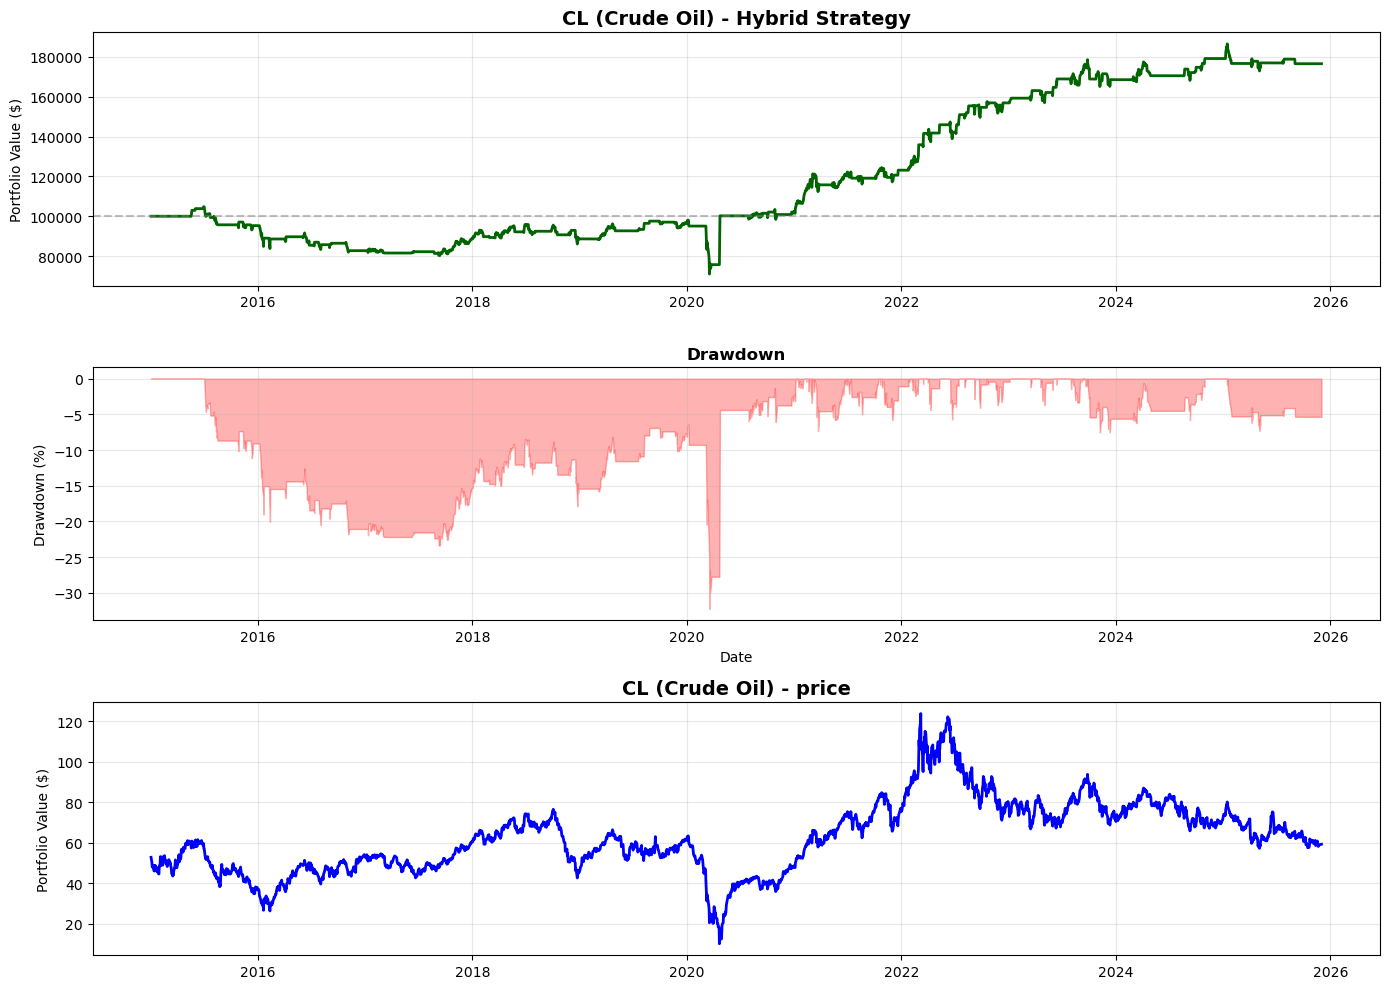

In [21]:
print(commodity_data['CL']['Close'])

# Plot CL equity curve
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Equity
ax1 = axes[0]
ax1.plot(result_cl.equity_curve.index, result_cl.equity_curve['TotalValue'], linewidth=2, color='darkgreen')
ax1.axhline(y=pm_cl.initial_capital, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('CL (Crude Oil) - Hybrid Strategy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[1]
drawdown = (result_cl.equity_curve['TotalValue'] / result_cl.equity_curve['TotalValue'].cummax() - 1) * 100
ax2.fill_between(drawdown.index, 0, drawdown, color='red', alpha=0.3)
ax2.set_title('Drawdown', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# Equity
ax3 = axes[2]
ax3.plot(commodity_data['CL'].index, commodity_data['CL']['Close'], linewidth=2, color='blue')
ax3.set_title('CL (Crude Oil) - price', fontsize=14, fontweight='bold')
ax3.set_ylabel('Portfolio Value ($)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Next Steps

### ✅ What Works
- Asset registry provides metadata for CL, NG, and other commodities
- Rollover handler calculates expiration dates
- Data loading works with yfinance
- Existing signals work on commodity data
- Backtesting infrastructure handles commodities

### 🔧 Enhancements Needed
1. Add contract multiplier awareness to position sizing
2. Integrate rollover costs into backtest results
3. Validate rollover dates vs. CME calendar
4. Add unit tests for asset registry and rollover handler